# Beginning
+ header
+ libraries
+ read in data 



In [1]:
#!pip install datasets

In [7]:
 34849 + 21995 +45564 +1441 +4202


108051

In [1]:
##### Purpose:  featurize the sentences, and make a naive bayes classifier
##### Author: Julia Cope
##### Creation Date: 4/23/23
##### Project: A2 NLP - capturing climate claims 
##### Inputs: 
##### Inputs: 03_Outputs/04_labeled_sampledata.csv
##### Inputs: 
##### Output: 
##### Output: 
##### Output: 


### libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import tensorflow as tf
import transformers
#from sklearn.metrics import classification_report, f1_score, confusion_matrix
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import random

#import tensorflow_decision_forests as tfdf

In [2]:
## read in data
#input_sentences = pd.read_csv('03_Outputs/04_labeled_sampledata.csv',parse_dates=['Date'])

input_sentences = pd.read_csv('03_Outputs/04D_FULL_labeled_sampledata.csv',parse_dates=['Date'])
del input_sentences['climate_score']
del input_sentences['likely']
del input_sentences['Date']
del input_sentences['index']
del input_sentences['company']
del input_sentences['Year']
input_sentences['sentences'] = input_sentences['sentences'].astype(str)
input_sentences.head()

,sentences,ClimateLabel
0,Any opinions expressed herein are statements o...,0
1,The Department reasons the NPRM is consistent ...,0
2,Factors that could cause actual results to dif...,1
3,[15] [ 1]: [ 2]: [ 3]:...,0
4,Among the changes are enhanced cleaning effort...,0


In [3]:
input_sentences= input_sentences.rename(columns = {'sentences':'text', 'ClimateLabel':'labels'})

In [4]:
input_sentences.head()

,text,labels
0,Any opinions expressed herein are statements o...,0
1,The Department reasons the NPRM is consistent ...,0
2,Factors that could cause actual results to dif...,1
3,[15] [ 1]: [ 2]: [ 3]:...,0
4,Among the changes are enhanced cleaning effort...,0


In [6]:
in_dataset = Dataset.from_pandas(input_sentences)
in_dataset = in_dataset.train_test_split(test_size=0.2, shuffle=True)

In [7]:
in_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1440
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 360
    })
})

In [43]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)


In [8]:
input_sentences["Words Per sent"] = input_sentences["text"].str.split().apply(len)


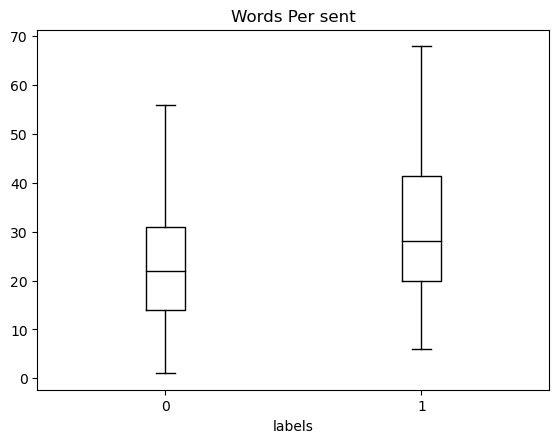

In [9]:
## make sure that the length of the sentences/documents are smaller than 512 tokens, which is the max of a transfomer

input_sentences.boxplot("Words Per sent", by="labels", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
#plt.xlabel("")
plt.show()

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [12]:
# hide_output
PR_encoded = in_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [13]:
PR_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1440
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 360
    })
})

# create a BERT classifier

+ load pretrained bert tokenizer and model
+ tokenize input sentences (labeled set)
+ change into tensorflow dataset datatype
+ compile and train model
+ evaluate model on prelabeled test data (get recall, f1 score)
+ extrapolate model onto unlabeled data


In [14]:
# hide_output
import torch
from transformers import AutoModelForSequenceClassification
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [15]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [20]:
from transformers import Trainer, TrainingArguments

batch_size = 2
logging_steps = len(PR_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-PR"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size)


In [21]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=PR_encoded["train"],
                  eval_dataset=PR_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt))

In [ ]:
PR_encoded["train"].column_names

In [ ]:
tokenizer_columns

In [ ]:
tokenizer_columns = tokenizer.model_input_names


tf_train_dataset = PR_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["ClimateLabel"], shuffle=True,
    batch_size=32)
tf_eval_dataset = PR_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["ClimateLabel"], shuffle=False,
    batch_size=32)

In [ ]:
tf_train_dataset

In [ ]:
tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=tf.keras.metrics.Recall())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

In [ ]:
# hide_output
train_encoded = train_dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
# hide_output
test_encoded = test_dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
tokenizer_columns

In [ ]:
train_encoded

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
batch_size=32 

# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = train_encoded.to_tf_dataset(
    columns=tokenizer_columns, label_cols=["ClimateLabel"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = test_encoded.to_tf_dataset(
    columns=tokenizer_columns, label_cols=["ClimateLabel"], shuffle=False,
    batch_size=batch_size)

In [ ]:
tf_train_dataset

In [ ]:
#https://keras.io/getting_started/faq/#how-can-i-freeze-layers-and-do-finetuning

tf_model.layers[0].trainable = False

In [ ]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
    metrics=tf.keras.metrics.Recall())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

In [ ]:
type(tf_model)

## Get confusion matrix
+ get predicted output for the test set from the .predict() method
+ you can get all the metrics directly from the above object
+ also get the y_pred so that we can plot the cnfusion matrix
+ get confusion matrix



In [ ]:
test_np = test_encoded['sentences']

In [ ]:
test_encoded

In [ ]:
tf_eval_dataset

In [ ]:
preds_output = tf_model.predict(tf_eval_dataset)

In [ ]:
tf_model.evaluate(tf_eval_dataset)

In [ ]:
np.argmax(preds_output.logits, axis=1)

In [ ]:

# Evaluate model with 
y_pred = np.round(model.predict([X_encoded['input_ids'], X_encoded['attention_mask']]))
report = classification_report(y, y_pred)
print(report) 

In [ ]:
cm = confusion_matrix(y, y_pred)
print(cm)

## Save the model 

In [ ]:
from tensorflow import keras

# assume you have a functional model called `my_model`
# save the model to a file called `my_model.h5`
tf_model.save('07A_distilbert_classifier',save_format="tf")

# Save the model 
+ save the model


In [ ]:
type(model)

In [ ]:
from tensorflow import keras

# assume you have a functional model called `my_model`
# save the model to a file called `my_model.h5`
model.save('my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from transformers import TFBertModel

# Define a dictionary to map the custom object name to the actual class
custom_objects = {'TFBertModel': TFBertModel}

# Load the saved model from the file, passing the custom_objects dictionary to the 'custom_objects' argument
loaded_model = load_model('my_model.h5', custom_objects=custom_objects)


In [ ]:
type(loaded_model)

# Use model to predict labels of unseen data 
+ load unseen data
+ tokenize sentences 
+ predict labels
+ turn probabilities into binary labels
+ add predicted labels to the df 

In [ ]:
# Load new data for prediction
unlabeled_data_df = pd.read_csv('03_Outputs/04_unlabeled_data.csv')

In [ ]:
unlabeled_data_df

In [ ]:
# select rows where the year column value is greater than 2017
df_filtered = unlabeled_data_df[unlabeled_data_df['Year'] > 2017]


In [ ]:
df_filtered

In [ ]:
#18 minutes

# Tokenize input sentences for new data
X_new_encoded = tokenizer(df_filtered['sentences'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')




In [ ]:
# Predict labels for new data
#y_pred = model.predict([X_new_encoded['input_ids'], X_new_encoded['attention_mask']])


In [ ]:

# Convert probability scores to binary labels
y_pred_binary = np.round(y_pred).astype(int)



In [ ]:
# Add predicted labels to new_df
df_filtered['predicted_label'] = y_pred_binary